In [14]:
import math
import random
import zipfile
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import urllib.request

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

MODEL_DIR = "../model"
RESULT_DIR = "../result"
DATA_DIR = "../data"

Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(RESULT_DIR).mkdir(parents=True, exist_ok=True)
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)

Using device: mps


In [15]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

EMBED_DIM = 100
WINDOW_SIZE = 5
MIN_COUNT = 1
SUBSAMPLE_T = 1e-5
NEG_K = 10
BATCH_SIZE = 2048
EPOCHS = 50
LR = 0.002

TEXT8_ZIP = Path(DATA_DIR) / "text8.zip"
TEXT8_TXT = Path(DATA_DIR) / "text8"
WS353_ZIP = Path(DATA_DIR) / "wordsim353.zip"
WS353_CSV = Path(DATA_DIR) / "wordsim353_combined.csv"
GOOGLE_ANALOGY = Path(DATA_DIR) / "questions-words.txt"


def download_file(url: str, dst_path: Path, desc: str = ""):
    if dst_path.exists():
        print(f"[OK] {desc or dst_path.name} already exists at {dst_path}")
        return
    print(f"[Download] {desc or dst_path.name} from {url}")
    dst_tmp = dst_path.with_suffix(".downloading")
    dst_tmp.unlink(missing_ok=True)
    urllib.request.urlretrieve(url, dst_tmp)
    dst_tmp.replace(dst_path)
    print(f"[Saved] -> {dst_path}")


try:
    download_file("http://mattmahoney.net/dc/text8.zip", TEXT8_ZIP, "text8.zip")
except Exception as e:
    print("Primary text8 URL failed, trying a mirror...")
    download_file("https://cs.fit.edu/~mmahoney/compression/text8.zip", TEXT8_ZIP, "text8.zip (mirror)")

if not TEXT8_TXT.exists():
    print("[Unzip] Extracting text8...")
    with zipfile.ZipFile(TEXT8_ZIP, 'r') as zf:
        zf.extractall(Path(DATA_DIR))
    print(f"[OK] Extracted to {TEXT8_TXT}")
else:
    print("[OK] text8 already extracted.")

try:
    download_file("http://www.gabrilovich.com/resources/data/wordsim353/wordsim353.zip", WS353_ZIP, "wordsim353.zip")
except Exception as e:
    print("Primary WordSim353 URL failed, using GitHub raw combined.csv mirror...")
    download_file("https://raw.githubusercontent.com/igorbrigadir/word-embeddings-benchmarks/master/data/word-sim/wordsim353/combined.csv",
                  WS353_CSV, "wordsim353 combined.csv (mirror)")

if WS353_ZIP.exists() and not WS353_CSV.exists():
    print("[Unzip] Extracting WordSim353...")
    with zipfile.ZipFile(WS353_ZIP, 'r') as zf:
        member = None
        for name in zf.namelist():
            if name.lower().endswith("combined.csv"):
                member = name
                break
        if member is None:
            for name in zf.namelist():
                if "combined.csv" in name.lower():
                    member = name
                    break
        if member:
            with zf.open(member) as f, open(WS353_CSV, "wb") as out:
                out.write(f.read())
            print(f"[OK] WordSim353 combined.csv -> {WS353_CSV}")
        else:
            print("[Skip] Could not find combined.csv in the zip; mirror may be used.")

try:
    download_file("https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt",
                  GOOGLE_ANALOGY, "Google analogy (questions-words.txt)")
except Exception as e:
    print("Primary analogy URL failed, trying another mirror...")
    download_file("https://raw.githubusercontent.com/3Top/word2vec-api/master/questions-words.txt",
                  GOOGLE_ANALOGY, "Google analogy (mirror)")

print("[Done] Downloads ready.")

[Download] text8.zip from http://mattmahoney.net/dc/text8.zip
[Saved] -> ../data/text8.zip
[Unzip] Extracting text8...
[OK] Extracted to ../data/text8
[Download] wordsim353.zip from http://www.gabrilovich.com/resources/data/wordsim353/wordsim353.zip
[Saved] -> ../data/wordsim353.zip
[Unzip] Extracting WordSim353...
[OK] WordSim353 combined.csv -> ../data/wordsim353_combined.csv
[Download] Google analogy (questions-words.txt) from https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt
[Saved] -> ../data/questions-words.txt
[Done] Downloads ready.


Total tokens (raw): 17,005,207
Vocab size (min_count=1): 253,854
Final vocab size with <UNK>: 253,855
Tokens after subsampling (t=1e-05): 5,882,862 (kept 34.59%)


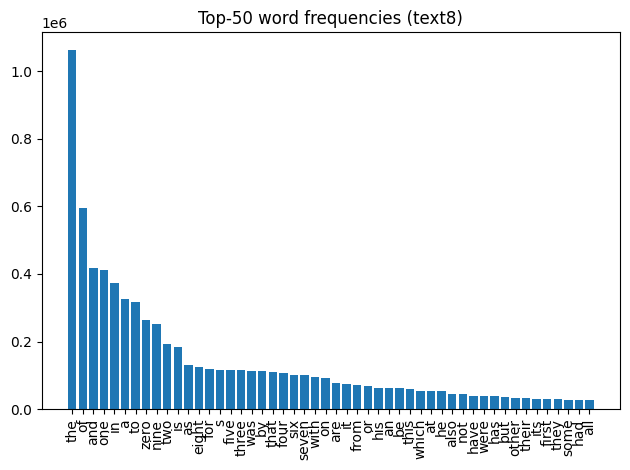

[Saved] ../result/freq_top50.png


In [3]:
with open(TEXT8_TXT, "r") as f:
    text = f.read().strip()

tokens = text.split()
total_tokens = len(tokens)
print(f"Total tokens (raw): {total_tokens:,}")

freq = Counter(tokens)
vocab = {w for w, c in freq.items() if c >= MIN_COUNT}
print(f"Vocab size (min_count={MIN_COUNT}): {len(vocab):,}")

# Map to ids
stoi = {}
itos = []
for w, c in freq.items():
    if c >= MIN_COUNT:
        stoi[w] = len(itos)
        itos.append(w)
UNK = "<UNK>"
stoi[UNK] = len(itos)
itos.append(UNK)

vocab_size = len(itos)
print(f"Final vocab size with <UNK>: {vocab_size:,}")

ids = np.array([stoi.get(w, stoi[UNK]) for w in tokens], dtype=np.int64)


def subsample(sequence_ids, freq_counter, t=SUBSAMPLE_T):
    if t <= 0:
        return sequence_ids
    total = sum(freq_counter.values())
    kept = []
    for w_id in sequence_ids:
        w = itos[w_id] if w_id < len(itos) else UNK
        f = freq_counter[w] / total if w in freq_counter else 0
        # P_keep = (sqrt(f/t) + 1) * (t/f)
        p_keep = (math.sqrt(f / t) + 1) * (t / max(f, 1e-12))
        if random.random() < min(p_keep, 1.0):
            kept.append(w_id)
    return np.array(kept, dtype=np.int64)


ids_sub = subsample(ids, freq, SUBSAMPLE_T)
print(f"Tokens after subsampling (t={SUBSAMPLE_T}): {len(ids_sub):,} (kept {(len(ids_sub)/len(ids))*100:.2f}%)")

top_items = freq.most_common(50)
plt.figure()
plt.bar(range(len(top_items)), [c for _, c in top_items])
plt.xticks(range(len(top_items)), [w for w, _ in top_items], rotation=90)
plt.title("Top-50 word frequencies (text8)")
plt.tight_layout()
plt.savefig(Path(RESULT_DIR) / "freq_top50.png", dpi=140)
plt.show()
print(f"[Saved] {Path(RESULT_DIR) / 'freq_top50.png'}")

In [4]:
counts = np.zeros(vocab_size, dtype=np.float64)
for w, c in freq.items():
    wid = stoi.get(w, stoi[UNK])
    counts[wid] += c
neg_dist = counts ** 0.75
neg_dist = neg_dist / neg_dist.sum()
neg_dist_t = torch.tensor(neg_dist, dtype=torch.float)


class SkipGramDataset(Dataset):
    def __init__(self, token_ids: np.ndarray, window_size: int):
        self.ids = token_ids
        self.window_size = window_size

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        center = self.ids[idx]
        w = random.randint(1, self.window_size)
        while True:
            offset = random.randint(-w, w)
            if offset != 0 and 0 <= idx + offset < len(self.ids):
                context = self.ids[idx + offset]
                break
        return int(center), int(context)


class NegativeSampler:
    def __init__(self, dist: torch.Tensor):
        self.dist = dist

    def sample(self, num_samples: int):
        return torch.multinomial(self.dist, num_samples=num_samples, replacement=True)


neg_sampler = NegativeSampler(neg_dist_t)


def collate_fn(batch):
    centers, contexts = zip(*batch)
    centers = torch.tensor(centers, dtype=torch.long)
    contexts = torch.tensor(contexts, dtype=torch.long)
    negatives = neg_sampler.sample(len(batch) * NEG_K).view(len(batch), NEG_K)
    return centers, contexts, negatives


dataset = SkipGramDataset(ids_sub, WINDOW_SIZE)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn, drop_last=True)

print(f"Dataset size: {len(dataset):,} (pairs per epoch ~ dataset size)")
print(f"Dataloader batch_size={BATCH_SIZE}, NEG_K={NEG_K}")

Dataset size: 5,882,862 (pairs per epoch ~ dataset size)
Dataloader batch_size=2048, NEG_K=10


In [5]:
class SGNS(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, embed_dim)
        self.out_embed = nn.Embedding(vocab_size, embed_dim)
        self._init_weights()

    def _init_weights(self):
        # Similar to word2vec: uniform in [-0.5/embed_dim, 0.5/embed_dim]
        bound = 0.5 / EMBED_DIM
        nn.init.uniform_(self.in_embed.weight, -bound, bound)
        nn.init.constant_(self.out_embed.weight, 0.0)

    def forward(self, center_ids, pos_context_ids, neg_ids):
        """
        center_ids: (B,)
        pos_context_ids: (B,)
        neg_ids: (B, K)
        returns: scalar loss
        """
        v = self.in_embed(center_ids)           # (B, D)
        u_pos = self.out_embed(pos_context_ids)  # (B, D)
        u_neg = self.out_embed(neg_ids)         # (B, K, D)

        # positive score: v · u_pos
        pos_score = torch.sum(v * u_pos, dim=1)  # (B,)
        # negative score: v · u_neg -> (B, K)
        neg_score = torch.bmm(u_neg, v.unsqueeze(2)).squeeze(2)

        # loss = - [log σ(pos) + Σ log σ(-neg)]
        pos_loss = torch.log(torch.sigmoid(pos_score) + 1e-12)
        neg_loss = torch.log(torch.sigmoid(-neg_score) + 1e-12).sum(1)
        loss = -(pos_loss + neg_loss).mean()
        return loss


model = SGNS(vocab_size, EMBED_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
print(model)

SGNS(
  (in_embed): Embedding(253855, 100)
  (out_embed): Embedding(253855, 100)
)


Start training...


Epoch 50/50: 100%|██████████| 2872/2872 [01:14<00:00, 38.81it/s, loss=2.3432]


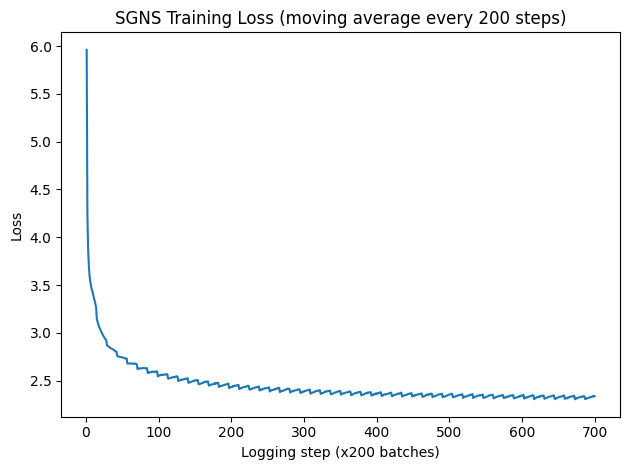

[Saved] ../result/training_loss.png
[Saved] checkpoint -> ../model/sgns_text8.pt


In [6]:
train_losses = []
log_interval = 200

print("Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    ema_loss = None

    with tqdm(total=len(loader), desc=f"Epoch {epoch}/{EPOCHS}", dynamic_ncols=True, leave=True) as pbar:
        for step, (centers, contexts, negatives) in enumerate(loader, start=1):
            centers = centers.to(device, non_blocking=False)
            contexts = contexts.to(device, non_blocking=False)
            negatives = negatives.to(device, non_blocking=False)

            optimizer.zero_grad(set_to_none=True)
            loss = model(centers, contexts, negatives)
            loss.backward()
            optimizer.step()

            val = loss.item()
            running += val
            ema_loss = val if ema_loss is None else 0.98 * ema_loss + 0.02 * val

            if step % log_interval == 0:
                avg = running / log_interval
                train_losses.append(avg)
                running = 0.0

            pbar.set_postfix(loss=f"{ema_loss:.4f}")
            pbar.update(1)

plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel("Logging step (x200 batches)")
plt.ylabel("Loss")
plt.title("SGNS Training Loss (moving average every 200 steps)")
plt.tight_layout()
loss_png = Path(RESULT_DIR) / "training_loss.png"
plt.savefig(loss_png, dpi=140)
plt.show()
print(f"[Saved] {loss_png}")

ckpt_path = Path(MODEL_DIR) / "sgns_text8.pt"
torch.save({
    "state_dict": model.state_dict(),
    "itos": itos,
    "stoi": stoi,
    "config": {
        "embed_dim": EMBED_DIM,
        "window_size": WINDOW_SIZE,
        "neg_k": NEG_K,
        "min_count": MIN_COUNT,
        "subsample_t": SUBSAMPLE_T
    }
}, ckpt_path)
print(f"[Saved] checkpoint -> {ckpt_path}")

In [7]:
W_in = model.in_embed.weight.detach().cpu().numpy()
W_out = model.out_embed.weight.detach().cpu().numpy()
E = W_in

E_norm = E / (np.linalg.norm(E, axis=1, keepdims=True) + 1e-12)


def word_id(w: str) -> int:
    return stoi.get(w, stoi[UNK])


def most_similar(query: str, topn: int = 10):
    qid = word_id(query)
    qv = E_norm[qid:qid+1]
    sims = (E_norm @ qv.T).ravel()
    sims[qid] = -1.0
    top_idx = np.argpartition(-sims, range(topn))[:topn]
    top_idx = top_idx[np.argsort(-sims[top_idx])]
    return [(itos[i], float(sims[i])) for i in top_idx]


for q in ["king", "queen", "man", "woman", "paris", "france", "london", "music"]:
    if q in stoi:
        print(f"\nTop similar to '{q}':")
        for w, s in most_similar(q, topn=8):
            print(f"  {w:>12s}  {s: .4f}")
    else:
        print(f"\n'{q}' not in vocabulary (min_count={MIN_COUNT}).")


Top similar to 'king':
  kasenzangakhona   0.7369
           elr   0.7164
        hierax   0.6888
          nuga   0.6863
   kabhekuzulu   0.6829
       gentius   0.6819
          hael   0.6815
     mwambutsa   0.6814

Top similar to 'queen':
     elizabeth   0.6855
  unfashionably   0.6667
        kassav   0.6592
          cleg   0.6288
       monarch   0.6268
        alfrun   0.6238
  amalaswintha   0.6233
      tahpenes   0.6213

Top similar to 'man':
         volas   0.6441
          braw   0.5942
          weit   0.5856
        henica   0.5602
       alcesti   0.5573
         indwe   0.5486
        jaddua   0.5381
       havanna   0.5328

Top similar to 'woman':
          depa   0.7147
     spiritosa   0.6636
     morbinosi   0.6610
         komit   0.6397
        barrek   0.6357
    peirithous   0.6319
       billaba   0.6295
        sagace   0.6222

Top similar to 'paris':
         debat   0.7260
   montorgueil   0.7069
         nrale   0.6916
       bagneux   0.6880
     couve

Pairs used: 353/353
WordSim-353 Spearman correlation: 0.6867


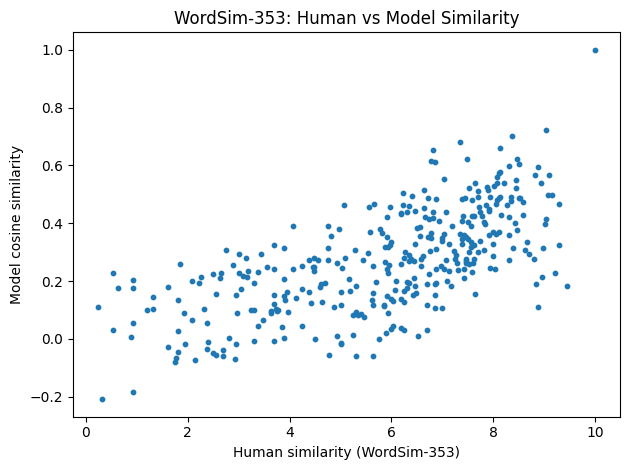

[Saved] ../result/wordsim353_scatter.png


In [8]:
if WS353_CSV.exists():
    ws = pd.read_csv(WS353_CSV)
else:
    ws = pd.read_csv("https://raw.githubusercontent.com/igorbrigadir/word-embeddings-benchmarks/master/data/word-sim/wordsim353/combined.csv")

sim_scores = []
human_scores = []
kept_rows = 0

for _, row in ws.iterrows():
    w1 = str(row.iloc[0]).strip().lower()
    w2 = str(row.iloc[1]).strip().lower()
    human = float(row.iloc[2])

    if w1 in stoi and w2 in stoi:
        v1 = E_norm[word_id(w1)]
        v2 = E_norm[word_id(w2)]
        sim = float(np.dot(v1, v2))
        sim_scores.append(sim)
        human_scores.append(human)
        kept_rows += 1

print(f"Pairs used: {kept_rows}/{len(ws)}")

sim_rank = pd.Series(sim_scores).rank(method='average')
human_rank = pd.Series(human_scores).rank(method='average')
spearman = sim_rank.corr(human_rank, method='pearson')
print(f"WordSim-353 Spearman correlation: {spearman:.4f}")

plt.figure()
plt.scatter(human_scores, sim_scores, s=10)
plt.xlabel("Human similarity (WordSim-353)")
plt.ylabel("Model cosine similarity")
plt.title("WordSim-353: Human vs Model Similarity")
plt.tight_layout()
scatter_png = Path(RESULT_DIR) / "wordsim353_scatter.png"
plt.savefig(scatter_png, dpi=140)
plt.show()
print(f"[Saved] {scatter_png}")